<h1><center> PPOL564 | DS1: Foundations </center><h1>
<h3><center> Lecture 25 <br><br><font color='grey'> 
Sampling </font></center></h3>

### Today's Topics

- Resampling methods
- MCMC

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import statsmodels.formula.api as sm
import warnings
import requests
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Resampling 

### Sampling with replacement

In [2]:
grades = ["a","b","c","d"]
for i in range(10):
    sample = resample(grades, replace=True, n_samples=10)
    print(sample)

['b', 'b', 'a', 'b', 'b', 'd', 'a', 'a', 'c', 'b']
['d', 'd', 'c', 'b', 'd', 'c', 'b', 'd', 'a', 'd']
['c', 'd', 'd', 'b', 'a', 'c', 'b', 'd', 'd', 'b']
['d', 'a', 'c', 'b', 'd', 'a', 'b', 'a', 'c', 'c']
['a', 'd', 'd', 'a', 'd', 'd', 'c', 'c', 'd', 'd']
['c', 'c', 'c', 'b', 'a', 'd', 'c', 'd', 'd', 'd']
['d', 'c', 'a', 'd', 'a', 'b', 'c', 'c', 'c', 'd']
['c', 'd', 'a', 'b', 'a', 'a', 'd', 'c', 'b', 'd']
['b', 'b', 'd', 'b', 'c', 'c', 'c', 'c', 'b', 'd']
['b', 'b', 'c', 'd', 'a', 'd', 'd', 'a', 'd', 'b']


### Sampling without replacement

In [3]:
grades = ["a","b","c","d"]
for i in range(10):
    sample = resample(grades, replace=False, n_samples=4)
    print(sample)

['d', 'c', 'b', 'a']
['c', 'b', 'a', 'd']
['d', 'b', 'a', 'c']
['d', 'b', 'a', 'c']
['b', 'd', 'a', 'c']
['d', 'c', 'b', 'a']
['b', 'd', 'a', 'c']
['a', 'b', 'd', 'c']
['d', 'b', 'a', 'c']
['a', 'c', 'd', 'b']


We can't sample beyond the number of elements we have in the set, since we're not replacing.

In [4]:
# THIS CODE CHUNK BREAKS

# grades = ["a","b","c","d"]
# for i in range(10):
#     sample = resample(grades, replace=False, n_samples=10)
#     print(sample)

### Permutation Test

Say we had data on the age of all passengers in a 2 buses.

In [5]:
passengers_age_bus1 = np.array([42,24,56,33,59,74,19,29])
passengers_age_bus2 = np.array([17,55,12,31,26,29,8,30,10])

Calculate the difference in means between the two groups.

In [6]:
diff_obs = passengers_age_bus1.mean() - passengers_age_bus2.mean()
diff_obs

17.77777777777778

Is the difference in means statistically significant? Naturally, we could use a difference in means (t-test) to figure this out. 

In [7]:
st.ttest_ind(passengers_age_bus1,passengers_age_bus2)

Ttest_indResult(statistic=2.152994626017182, pvalue=0.04800157061606202)

But if we didn't know about the t-test or the t-test wasn't feasible given the complexity of the algorithm. What we do then? Randomly permute the data!

For a "_**permutation test**_", we're going to generate a null distribution (i.e. a distribution that assumes the null hypothesis). We're going to do this by randomly generating different combinations of passengers on each bus. We do this by _pooling_ all passengers and then randomly splitting them. This yields a distribution that contains all possible values of the test statistic for different arrangements (permutations) of the observed data. 

We're then going to compare the observed difference in means (which we calculated above) from the null distribution to estimate the likelihood of observing the mean we observed.

In [8]:
i = 0; store = []
N_iterations = 10000

# Put all passengers into one bus. 
pooled = []
pooled.extend(passengers_age_bus1)
pooled.extend(passengers_age_bus2)
pooled = np.array(pooled)


while i < N_iterations:
    
    # Randomly shuffle 
    np.random.shuffle(pooled)
    
    # Split back into two busses
    b1 = pooled[:8]
    b2 = pooled[8:]
    
    # Calculate the diff in means and store
    store.append(b1.mean() - b2.mean())

    i += 1 # then iterate

store = np.array(store) # convert to numpy array

Let's plot the null distribution and our observed value. 

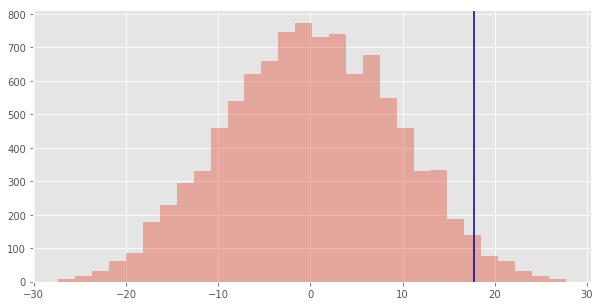

In [9]:
plt.figure(figsize=(10,5))
ax = sns.distplot(store,kde=False,bins=30)
ax.axvline(diff_obs,color="darkblue")
plt.show()

Calculate the P-value (for one tail)

In [10]:
(sum(store >= diff_obs))/(len(store))

0.0244

In [11]:
(sum(store <= diff_obs))/(len(store))

0.9769

### Bootstrapping

Bootstrapping is a way of taking repeated samples with replacement to generate a probability distribution (standard error) for an estimate.

> "Bootstrapping is a statistical method for estimating the sampling distribution of an estimator by sampling with replacement from the original sample, most often with the purpose of deriving robust estimates of standard errors and confidence intervals of a population parameter like a mean, median, proportion, odds ratio, correlation coefficient or regression coefficient. It may also be used for constructing hypothesis tests. It is often used as a robust alternative to inference based on parametric assumptions when those assumptions are in doubt, or where parametric inference is impossible or requires very complicated formulas for the calculation of standard errors." [wiki](https://en.wikipedia.org/wiki/Resampling_(statistics))

Let's first generate some fake data. 

In [12]:
np.random.seed(1234)
N = 2000
x = np.random.normal(size=N)
y = 1 + 2*x + np.random.normal(loc=0,scale=.5,size=N)
X = np.column_stack([np.ones(N),x])

Let's then implement the bootstrapping procedure.

In [13]:
store_beta = [] # Container to store our bootstrapped est. of B1
i = 0           # Index to track iterations
n_iterations = 25000 # Number of bootstrap iterations to run. 
index = np.array([i for i in range(N)]) # Index on the data

while i < n_iterations:
    
    # Grab a random sample of rows w/ replacement. 
    grab_these = resample(index,replace=True,n_samples=round(N*.5))

    # Grab just those sampled rows 
    y_boot = y[grab_these]
    X_boot = X[grab_these,:]

    # Calculate the Beta estimates (using our LA formulation)
    B = np.linalg.inv(X_boot.T.dot(X_boot)).dot(X_boot.T.dot(y_boot)) 
    
    # Store value for B1
    store_beta.append(B[1])
    i += 1 # Index the value. 
    
# convert stored values to a numpy array 
store_beta = np.array(store_beta)

Let's plot the bootstrapped distribution for $\beta_1$

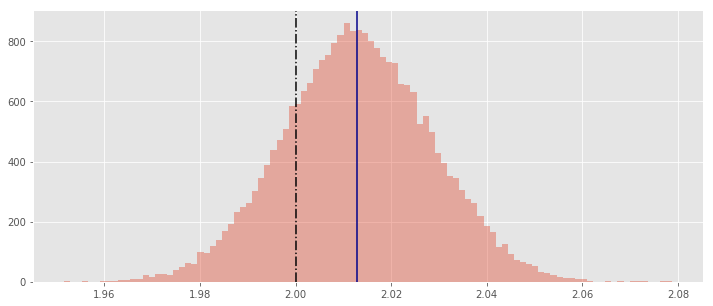

In [14]:
plt.figure(figsize=(12,5))
ax = sns.distplot(store_beta,kde=False,bins=100)
ax.axvline(store_beta.mean(),color="darkblue") # estimated value of b1
ax.axvline(2,color="black",ls="-.") # Real value of b1
plt.show()

Now we can use `np.quantiles()` to grab the values that correspond with a 95% confidence interval

In [15]:
ci = np.quantile(store_beta,[.025,.975])
ci

array([1.98284438, 2.04315045])

Let's calculate a P-value

In [16]:
(sum(store_beta <= 0))/(len(store_beta))

0.0

How much do our bootstrapped confidence intervals differ from the analytic confidence intervals?

In [17]:
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 3.210e+04
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        07:38:47   Log-Likelihood:                -1424.4
No. Observations:                2000   AIC:                             2853.
Df Residuals:                    1998   BIC:                             2864.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0062      0.011     91.142      0.000       0.985       1.028
x1             2.0129      0.011    179.163      0.000       1.991       2.035
==============================================================================
Omnibus:                        4.774   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.743
Skew:                          -0.100   Prob(JB):                       0.0933
Kurtosis:                       2.869   Cond. No.                         1.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Monte Carlo Integration 

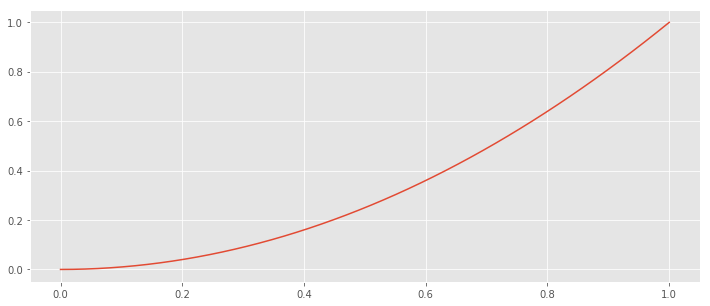

In [18]:
# A function to integrate
def f(x): 
    return x**2
    
# Generate a linear sequence of numbers 
x = np.linspace(0,1)

# Plot the function
plt.figure(figsize=(12,5))
sns.lineplot(x,f(x))
plt.show()

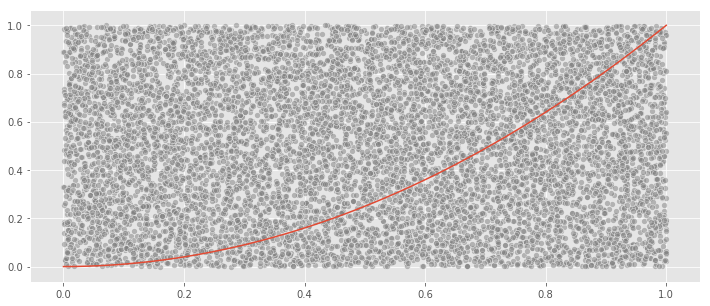

In [19]:
np.random.seed(1234)
n = 10000
xx = np.random.uniform(low=0,high=1,size=n)
yy = np.random.uniform(low=0,high=1,size=n)

# Plot the function and points
plt.figure(figsize=(12,5))
sns.lineplot(x,f(x))
sns.scatterplot(xx,yy,color="grey",alpha=.5)
plt.show()

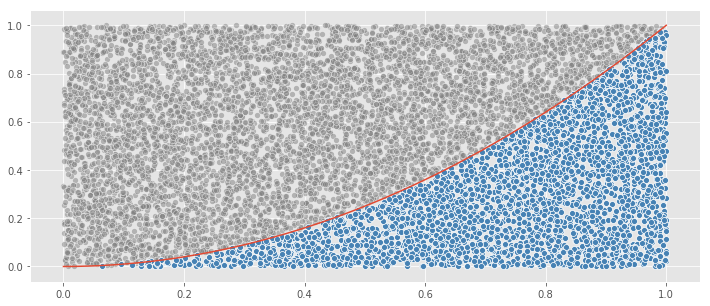

In [20]:
# Locate all points below the curve
def under_the_curve(x,y):
    return y < x**2

# Store the boolean values
z = under_the_curve(xx,yy)

# Plot the function and points
plt.figure(figsize=(12,5))
sns.lineplot(x,f(x))
sns.scatterplot(xx,yy,color="grey",alpha=.5)
sns.scatterplot(xx[z],yy[z],color="steelblue")
plt.show()

Sum up all the points the fell underneath the curve to get the integral

In [21]:
sum(z)/len(z)

0.3348

Compare the computed results to a more analytic approximation, like quadrature. 

In [22]:
import scipy.integrate as integrate
integrate.quad(f,0,1)[0]

0.33333333333333337

Not bad!

# Markov Chain Monte Carlo (MCMC)

> "In statistics, Markov chain Monte Carlo (MCMC) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain. The more steps that are included, the more closely the distribution of the sample matches the actual desired distribution." ([Wiki](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo))


Suppose that there is some target distribution that we'd like to sample from, but we cannot just draw independent samples from that distribution (i.e. we don't know its exact shape and form). Instead, with MCMC, we jump around the space and explore it. Generally speaking, a Markov chain wanders around a state space, only remembering where it has been in the last step. 

There are various algorithms that accomplish task. Some are quite sophisticated, but they all aim to do the same thing, sample from the area underneath a sample from an unknown distribution. 

### Metropolis-Hastings Sampler

Say we have some distribution that we want to sample from --- specifically, say this is a probability distribution that reflect the posterior distribution for a Bayesian model we're running. 

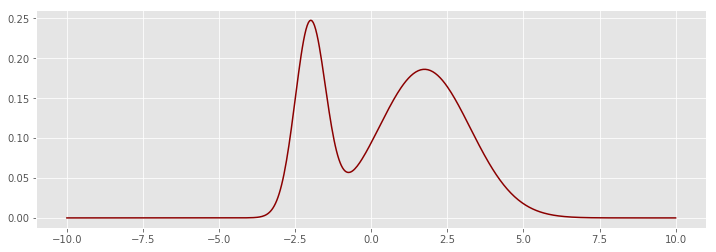

In [23]:
# Our distribution looks something like this. 
def our_dist(x):
    return .3*st.norm.pdf(x,loc=-2,scale=.5) + (1-.3)*st.norm.pdf(x,loc=1.75,scale=1.5)

# Plot our target distribution
x = np.linspace(-10,10,num=500)
plt.figure(figsize=(12,4))
sns.lineplot(x,our_dist(x),color="darkred")
plt.show()

Here we'll define a really simple algorithm that "proposes" a random step and then only takes that step if its sufficiently close to the previous step that it took. So we're only going to remember two things: where we were, and where we might go (this is the Markov part). 

Below is the proposal function. Here let's just draw from a normal distribution with standard deviation of 4 (the larger the standard deviation, the larger the proposal). We'll put our current position in as the mean for this distribution. 

In [24]:
def proposal(x):
    return np.random.normal(loc=x,scale=4,size=1)[0]

Now let's set up a step function that offers up a proposition for a step, and then only takes that step if its sufficiently close to the previous step. 

In [25]:
def step(x,target_func,proposal):
    
    # Pick a new point (the proposal)
    proposed_point = proposal(x)
    where_should_I_jump = target_func(proposed_point)
    where_am_I_currently = target_func(x)
    
    # Acceptance probability
    should_I_jump = min(1,where_should_I_jump/where_am_I_currently)
    
    if should_I_jump is None:
        return 0
    
    # Randomly determine whether to take the step or not
    if np.random.uniform(low=0,high=1,size=1) < should_I_jump:
        x = proposed_point
    
    # Return the step
    return x

Finally, Let's iterate through, proposing a step and only taking that step if it's close to our target distribution. This keeps use where we want to be. If we ever deviate too far, we won't take a step. This has a nice property that allows use to efficiently explore the target distribution. 

In [26]:
def explore(x,target_func,proposal,n_steps):
    res = [None]*n_steps
    for i in range(n_steps):
        x = step(x,target_func = target_func,proposal=proposal)
        res[i] = x
    return np.array(res)

Let's run.

In [27]:
output1 = explore(1,target_func=our_dist,proposal=proposal,n_steps = 500)

Plot the time series of each step.

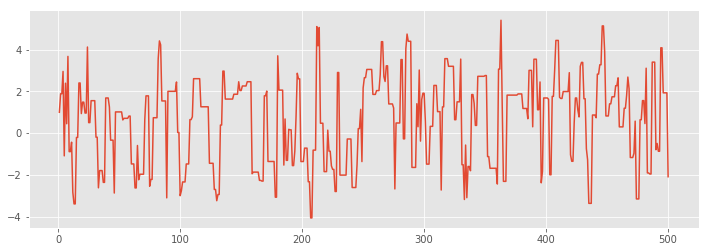

In [28]:
steps = np.arange(1, len(output1) + 1, 1 ) # count each step
plt.figure(figsize=(12,4))
sns.lineplot(steps,output1)
plt.show()

How well did we do in recovering the distribution?

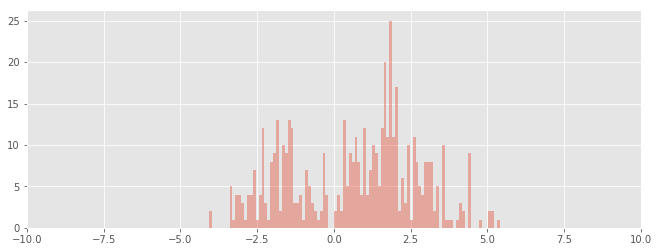

In [30]:
plt.figure(figsize=(11,4))
ax = sns.distplot(output1,bins=100,kde=False)
plt.xlim(-10, 10)
plt.show()

Let's run for longer (i.e. let's spend more time exploring the distribution)

In [31]:
output2 = explore(1,target_func=our_dist,proposal=proposal,n_steps = 20000)

Plot the time series of each step.

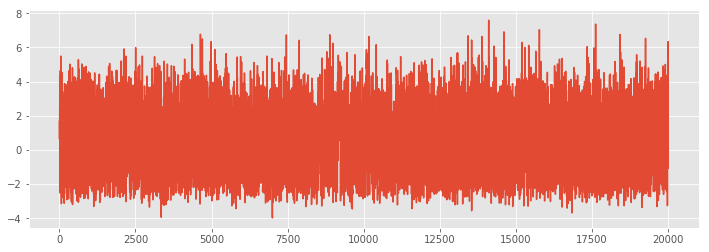

In [32]:
steps = np.arange(1, len(output2) + 1, 1 ) # count each step
plt.figure(figsize=(12,4))
sns.lineplot(steps,output2)
plt.show()

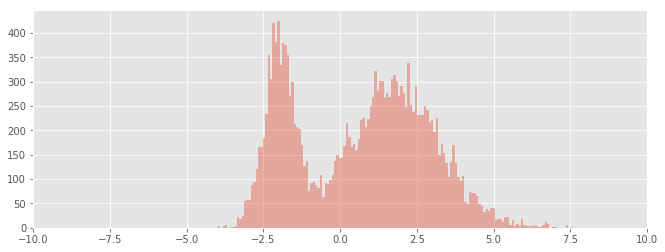

In [33]:
plt.figure(figsize=(11,4))
ax = sns.distplot(output2,bins=150,kde=False)
plt.xlim(-10, 10)
plt.show()